# 2.6 SubGraph: LangGraph Agent를 Node로 활용하는 방법

- [Adaptive-RAG: Learning to Adapt Retrieval-Augmented Large Language Models through Question Complexity](https://arxiv.org/abs/2403.14403)논문을 구현합니다
- LangGraph 공식문서의 흐름을 따라갑니다
    - 공식문서의 흐름은 간소화된 버전입니다
    - 실제 논문과 유사한 구현은 3.3강을 참고해주세요

![adaptive-rag](https://i.imgur.com/tbICSxY.png)

In [1]:
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
from typing import TypedDict
from langgraph.graph import StateGraph

class AgentState(TypedDict):
    query: str
    context: list
    answer: str

workflow = StateGraph(AgentState)

In [3]:
from langchain_tavily import TavilySearch

def web_search(state: AgentState) -> AgentState:
    """
    주어진 state를 기반으로 웹 검색을 수행합니다.
    Args:
        state (AgentState): 사용자의 질문을 포함한 에이전트의 현재 state.
    Returns:
        AgentState: 웹 검색 결과가 추가된 state를 반환합니다.
    """
    print("web_search")
    tavily_search = TavilySearch(
        max_results=3,
        topic="general",  # "news", "finance"
        include_answer=True,
        include_raw_content=True,
        include_images=True,        
        search_depth="advanced",  # "basic"
    )
    query = state["query"]
    results = tavily_search.invoke(query)
    return {"context": results}

c:\Users\limjangmook\Desktop\ANSWER_25\inflearn-langgraph-agent\.venv\Lib\site-packages\langchain_tavily\tavily_research.py:97: UserWarning: Field name "output_schema" in "TavilyResearch" shadows an attribute in parent "BaseTool"
  class TavilyResearch(BaseTool):  # type: ignore[override, override]
c:\Users\limjangmook\Desktop\ANSWER_25\inflearn-langgraph-agent\.venv\Lib\site-packages\langchain_tavily\tavily_research.py:97: UserWarning: Field name "stream" in "TavilyResearch" shadows an attribute in parent "BaseTool"
  class TavilyResearch(BaseTool):  # type: ignore[override, override]


- [rlm/rag-prompt](https://smith.langchain.com/hub/rlm/rag-prompt)
- HUMAN
    - You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
    - Question: {question} 
    - Context: {context} 
- Answer:

In [4]:
from langchain_classic import hub
from langchain_ollama import ChatOllama

llm_ollama = ChatOllama(model="llama3.1")

def web_generate(state: AgentState) -> AgentState:
    """
    주어진 문맥과 질문을 기반으로 답변을 생성합니다.
    Args:
        state (AgentState): 문맥과 질문을 포함한 에이전트의 현재 state.
    Returns:
        AgentState: 생성된 답변을 포함한 state를 반환합니다.
    """
    print("web_generate")
    query = state["query"]
    context = state["context"]
    generate_prompt = hub.pull("rlm/rag-prompt")
    generate_chain = generate_prompt | llm_ollama
    response = generate_chain.invoke({"question": query, "context": context})
    return {"answer": response}

c:\Users\limjangmook\Desktop\ANSWER_25\inflearn-langgraph-agent\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


- 간단한 질문에 답변을 하는 경우 작은 모델을 활용해서 비용을 저감하고, 답변 생성 속도를 향상시킬 수 있습니다

In [5]:
llm_basic = ChatOllama(model="mistral")

def basic_generate(state: AgentState) -> AgentState:
    """
    사용자의 질문에 기반하여 기본 답변을 생성합니다.
    Args:
        state (AgentState): 사용자의 질문을 포함한 에이전트의 현재 state.
    Returns:
        AgentState: 생성된 답변을 포함한 state를 반환합니다.
    """
    print("basic_generate")
    query = state["query"]
    response = llm_basic.invoke(query)
    return {"answer": response.content}

- 사용자의 질문이 들어오면 `router` 노드에서 사용자의 질문을 분석해서 적절한 노드로 이동합니다
    - 사용자의 질문에 관한 내용이 vector store에 있는 경우 `income_tax_agent` 노드로 이동합니다
    - 사용자의 질문이 간단한 경우 `basic_generate` 노드로 이동합니다
    - 사용자의 질문이 웹 검색을 통해 답변을 얻을 수 있는 경우 `web_search` 노드로 이동합니다

In [6]:
from typing import Literal
from pydantic import BaseModel, Field
from langchain_core.prompts import ChatPromptTemplate

class Route(BaseModel):
    target: Literal["vector_store", "web_search", "llm_basic"] = Field(
        description="The target for the query to answer"
    )
structured_llm = llm_basic.with_structured_output(Route)

router_system_prompt = """
    사용자의 질문에 대해 "vector_store", "web_search", "llm_basic" 셋 중 하나를 반환합니다.
    소득세 관련 정보가 포함되어 있으면 "vector_store"를 선택하고,
    웹 검색이 필요하면 "web_search"를 선택하고,
    간단한 질문에 대해 답하려면 "llm_basic"을 선택합니다.
"""

def router(state: AgentState) -> Literal["vector_store", "web_search", "llm_basic"]:
    """
    사용자의 질문에 기반하여 적절한 경로를 결정합니다.
    Args:
        state (AgentState): 사용자의 질문을 포함한 에이전트의 현재 state.
    Returns:
        Literal['vector_store', 'web_search', 'llm_basic']: 질문을 처리하기 위한 적절한 경로를 나타내는 문자열.
    """
    print("router")
    query = state["query"]
    router_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", router_system_prompt),
            ("user", "{query}"),
        ]
    )
    router_chain = router_prompt | structured_llm
    route = router_chain.invoke({"query": query})
    print(f"---> {route.target}")
    return route.target

- `node`를 추가하고 `edge`로 연결합니다

In [7]:
from income_tax_graph_self_RAG import graph as income_tax_subgraph
from langgraph.graph import START, END

workflow.add_node("income_tax_subgraph", income_tax_subgraph)
workflow.add_node("web_search", web_search)
workflow.add_node("web_generate", web_generate)
workflow.add_node("basic_generate", basic_generate)

workflow.add_conditional_edges(START, router, {
    "vector_store": "income_tax_subgraph",
    "web_search": "web_search",
    "llm_basic": "basic_generate",
})
workflow.add_edge("income_tax_subgraph", END)
workflow.add_edge("web_search", "web_generate")
workflow.add_edge("web_generate", END)
workflow.add_edge("basic_generate", END)

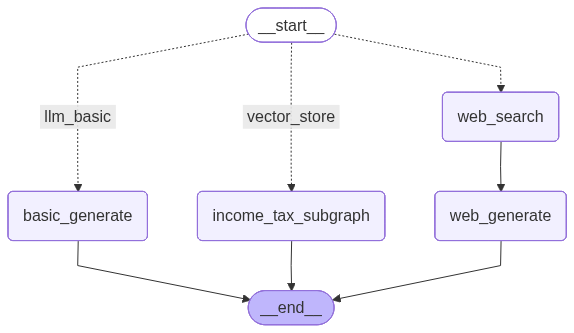

In [8]:
from IPython.display import display, Image

graph = workflow.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
question_1 = "연봉 5천만원인 거주자의 소득세는 얼마인가요?"  # vector_store
response_1 = graph.invoke({"query": question_1})
response_1

router
---> vector_store
retrieve
is_doc_relevant
---> relevant
generate
is_hallucinated
---> non-hallucinated
check_helpfulness
is_helpful
---> helpful


{'query': '연봉 5천만원인 거주자의 소득세는 얼마인가요?',
 'context': [Document(id='ae3d59f5-ef92-466c-9f41-ef3bef7714aa', metadata={'source': './documents/income_tax_ocr.text'}, page_content='cS 과세기간의 종합소득금액\n=== 페이지 39 시작 ===\n[일반 텍스트]\n법제처                                                            39                                                       국가법령정보센터\n소득세법\n[전문개정 2009. 12. 31.]\n \n제59조(근로소득세액공제) ①근로소득이 있는 거주자에 대해서는 그 근로소득에 대한 종합소득산출세액에서 다음의\n금액을 공제한다. <개정 2014. 1. 1., 2015. 5. 13.>\n② 제1항에도 불구하고 공제세액이 다음 각 호의 구분에 따른 금액을 초과하는 경우에 그 초과하는 금액은 없는 것\n으로 한다.<신설 2014. 1. 1., 2015. 5. 13., 2022. 12. 31.>\n1. 총급여액이 3천 300만원 이하인 경우: 74만원\n2. 총급여액이 3천 300만원 초과 7천만원 이하인 경우: 74만원 - [(총급여액 - 3천 300만원) × 8/1000]. 다만, 위 금\n액이 66만원보다 적은 경우에는 66만원으로 한다.\n3. 총급여액이 7천만원 초과 1억2천만원 이하인 경우: 66만원 - [(총급여액 - 7천만원) × 1/2]. 다만, 위 금액이 50만\n원보다 적은 경우에는 50만원으로 한다.\n4. 총급여액이 1억2천만원을 초과하는 경우: 50만원 - [(총급여액 - 1억2천만원) × 1/2]. 다만, 위 금액이 20만원보다\n적은 경우에는 20만원으로 한다.\n③ 일용근로자의 근로소득에 대해서 제134조제3항에 따른 원천징수를 하는 경우에는 해당 근로소득에 대한 산

In [11]:
print(response_1["answer"].content)

연봉 5천만원 인 거주자의 소득세는 66만원 - [(5000만원 - 7000만원) × 1/2] = 20만원입니다. 

(소득세법 제59조의5에 따른 규정에 따라)

다만, 위 금액이 20만원보다 적은 경우에는 20만원으로 한다.


In [16]:
question_2 = "판교 대장동 오늘 날씨 알려줘"  # web_search
response_2 = graph.invoke({"query": question_2})
response_2

router
---> web_search
web_search
web_generate


{'query': '판교 대장동 오늘 날씨 알려줘',
 'context': {'query': '판교 대장동 오늘 날씨 알려줘',
  'follow_up_questions': None,
  'answer': "Today in Pankyo Daejangdong, it's sunny with a temperature of 2°C and a wind from the west at 15 km/h. Humidity is 55%, and there's no precipitation.",
  'images': ['https://img1.daumcdn.net/thumb/R800x0/?scode=mtistory2&fname=https://blog.kakaocdn.net/dn/cbgMOm/btsEYI7dMWT/J0oYLPFhEcIl8wgLGK59Z0/img.jpg',
   'https://image.hogangnono.com/image/original/apt/dB3de/20190415200524_9wEAedYMkqG1FGGzI8?s=2048x180&t=outside&q=100',
   'https://t1.daumcdn.net/news/202301/30/chosun/20230130074107911bazr.jpg',
   'https://i.ytimg.com/vi/lPfSRUZx_bQ/maxresdefault.jpg',
   'https://img1.daumcdn.net/thumb/R1280x0.fjpg/?fname=http://t1.daumcdn.net/brunch/service/user/b3p2/image/JjwFuGFvdjFSHQ1KleNHDKKeixk.jpg'],
  'results': [{'url': 'https://www.korea247.kr/south-korea/gyeonggi-do/weather-daejangdong/',
    'title': '대장동 오늘 날씨 | 실시간 기온·강수 예보 확인',
    'content': '풍향: 서\n\n대한민국 날씨\n\n대장

In [18]:
print(response_2["answer"].content)

대장동의 현재 날씨는 주변 기온이 2°C로 밝고 조용한 상태입니다.


In [19]:
question_3 = "대한민국의 수도는 어디인가요?"  # llm_basic
response_3 = graph.invoke({"query": question_3})
response_3

router
---> llm_basic
basic_generate


{'query': '대한민국의 수도는 어디인가요?', 'answer': ' 대한민국의 수도는 서울입니다.'}

In [20]:
print(response_3["answer"])

 대한민국의 수도는 서울입니다.
